In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from google.colab import files

In [18]:
!pip install opendatasets
import opendatasets as od

In [19]:
od.download("https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset")

Skipping, found downloaded files in "./rice-image-dataset" (use force=True to force download)


Total Images per Class:
Ipsala: 15000 images
Jasmine: 15000 images
Arborio: 15000 images
Karacadag: 15000 images
Basmati: 15000 images


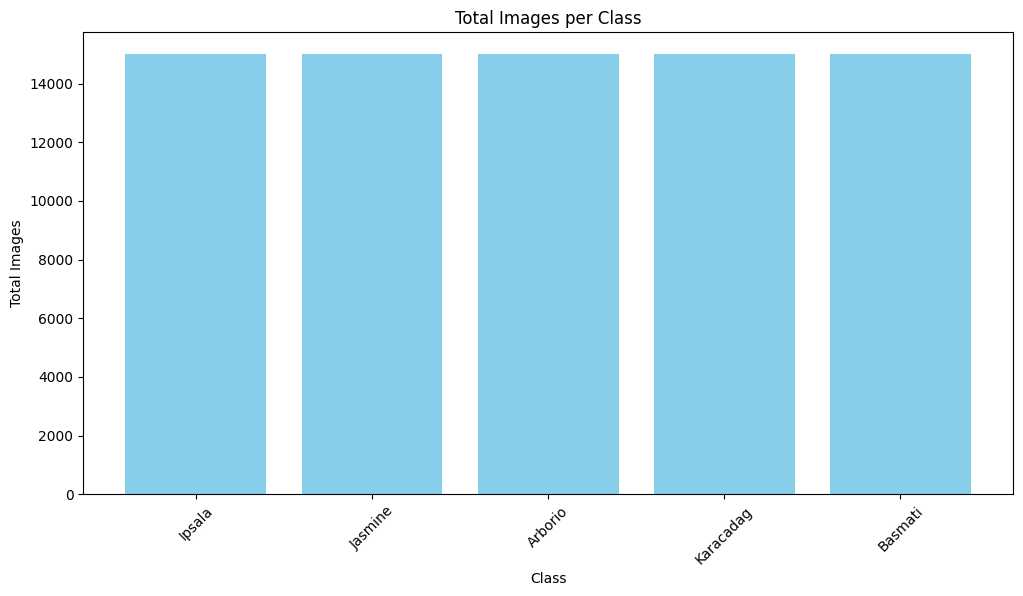

In [20]:
import os
import matplotlib.pyplot as plt

# List of dataset directories
dataset_paths = ['/content/rice-image-dataset/Rice_Image_Dataset/']

# Initialize a dictionary to store the total number of images for each class
total_images_per_class = {}

# Loop through each dataset directory
for dataset_path in dataset_paths:
    # Loop through each folder in the dataset directory
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)

        if os.path.isdir(folder_path):
            # Count the total number of images in each folder
            total_images = len(os.listdir(folder_path))

            # Add information to the dictionary
            if folder_name in total_images_per_class:
                total_images_per_class[folder_name] += total_images
            else:
                total_images_per_class[folder_name] = total_images

# Print the total number of images for each class
print("Total Images per Class:")
for class_name, total_images in total_images_per_class.items():
    print(f"{class_name}: {total_images} images")

# Display the data in a bar chart
plt.figure(figsize=(12, 6))
plt.bar(total_images_per_class.keys(), total_images_per_class.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Total Images')
plt.title('Total Images per Class')
plt.xticks(rotation=45)
plt.show()


In [21]:
# Define constants
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 64
DATA_DIR = '/content/rice-image-dataset/Rice_Image_Dataset/'

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.3,
    fill_mode='nearest'
)

# Validation and test data generators without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# Flowing from directory for training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 52500 images belonging to 5 classes.
Found 22500 images belonging to 5 classes.


In [22]:
# Define the base model with pre-trained weights from ImageNet
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the sequential model
model = tf.keras.Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          1179712   
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 5)                

In [24]:
target = 0.99

class TargetCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') >= target and logs.get('val_accuracy') >= target:
                print(f"Accuracy and val_accuracy >= {target:.2%} of targets. Training stopped.")
                self.model.stop_training = True

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

callback = TargetCallback()

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[callback, reduce_lr],
    shuffle=True
)

Epoch 1/5
821/821 [==============================] - 351s 427ms/step - loss: 0.0746 - accuracy: 0.9754 - val_loss: 0.0530 - val_accuracy: 0.9818 - lr: 0.0010
Epoch 2/5
821/821 [==============================] - 344s 419ms/step - loss: 0.0615 - accuracy: 0.9796 - val_loss: 0.1022 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/5
821/821 [==============================] - 344s 419ms/step - loss: 0.0579 - accuracy: 0.9809 - val_loss: 0.0511 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 4/5
821/821 [==============================] - 344s 419ms/step - loss: 0.0551 - accuracy: 0.9820 - val_loss: 0.0465 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 5/5
821/821 [==============================] - 356s 433ms/step - loss: 0.0510 - accuracy: 0.9832 - val_loss: 0.1122 - val_accuracy: 0.9607 - lr: 0.0010


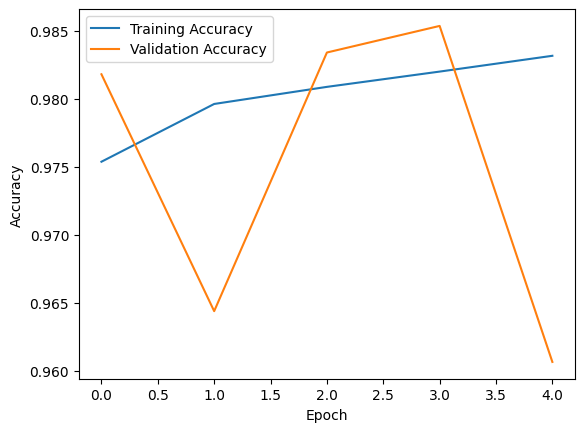

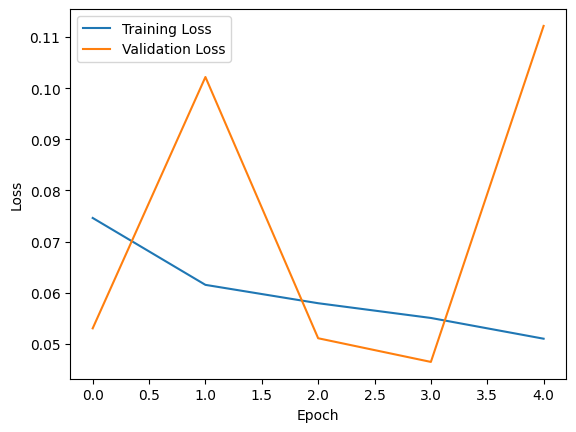

In [25]:
# Plotting model accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Saving Arborio (1000).jpg to Arborio (1000).jpg
Saving basmati (10001).jpg to basmati (10001).jpg
Saving Ipsala (10003).jpg to Ipsala (10003).jpg
Saving Jasmine (10).jpg to Jasmine (10).jpg
Saving Karacadag (10).jpg to Karacadag (10).jpg
1/1 [==============================] - 0s 22ms/step


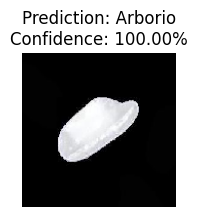

1/1 [==============================] - 0s 22ms/step


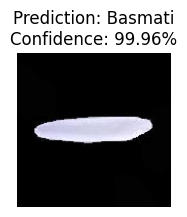

1/1 [==============================] - 0s 22ms/step


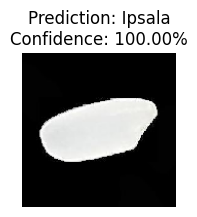

1/1 [==============================] - 0s 24ms/step


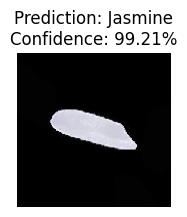

1/1 [==============================] - 0s 25ms/step


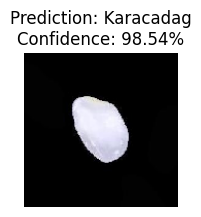

In [28]:
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Function to predict uploaded images
def predict_uploaded_image(model):
    uploaded_files = files.upload()

    for file_name in uploaded_files.keys():
        img_path = file_name
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)

        plt.figure(figsize=(2, 2))

        if predicted_class_index < len(classes):
            predicted_class = classes[predicted_class_index]
            confidence = np.max(prediction) * 100

            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2f}%')
            plt.show()
        else:
            print("Sorry, the prediction cannot be determined. The image is outside of the trained categories.")

# Calling the function to predict uploaded images
predict_uploaded_image(model)